In [55]:
import numpy as np
import matplotlib.pyplot as plt

def calcular_score_onda_refatorado(
    previsao_onda, tamanho_minimo, tamanho_ideal, tamanho_maximo
):
    """
    Calcula o score do tamanho da onda usando curvas suaves para uma representação mais realista.

    - Abaixo do mínimo: Curva quadrática suave de 0 a -100.
    - Mínimo ao Ideal: Curva senoidal crescente de 0 a 100 para uma subida suave.
    - Ideal ao Máximo: Curva cossenoidal decrescente de 100 a 0 para uma queda suave.
    - Acima do máximo: Decaimento exponencial de 0 a -100 para refletir o aumento do risco.
    """
    previsao_onda = np.asarray(previsao_onda, dtype=float)
    score = np.zeros_like(previsao_onda)

    # --- Seção 1: Onda menor que o limite mínimo (Flat a Pequeno) ---
    # A penalidade aumenta quadraticamente à medida que a onda se afasta (para baixo) do mínimo.
    # Isso cria uma curva suave que penaliza mais fortemente ondas muito pequenas.
    mask1 = previsao_onda < tamanho_minimo
    if tamanho_minimo > 0:
        # Normaliza a distância do mínimo e eleva ao quadrado para a curva.
        # O resultado vai de 0 (no tamanho_minimo) a -1 (em 0m).
        score[mask1] = -(((tamanho_minimo - previsao_onda[mask1]) / tamanho_minimo) ** 2)

    # --- Seção 2: Onda entre o limite mínimo e o ideal (Na medida certa) ---
    # Usamos meio período de uma onda senoidal para uma transição suave de 0 a 1.
    # O expoente 1.5 faz a curva subir um pouco mais rápido no início, refletindo
    # a empolgação de sair do "muito pequeno" para o "bom".
    mask2 = (previsao_onda >= tamanho_minimo) & (previsao_onda <= tamanho_ideal)
    if tamanho_ideal > tamanho_minimo:
        fator_normalizado = (previsao_onda[mask2] - tamanho_minimo) / (tamanho_ideal - tamanho_minimo)
        score[mask2] = np.sin(fator_normalizado * np.pi / 2) ** 1.5

    # --- Seção 3: Onda entre o ideal e o limite máximo (Grande mas ainda bom) ---
    # Usamos meio período de uma onda cossenoidal para uma transição suave de 1 a 0.
    # Isso conecta perfeitamente com o pico da seção anterior.
    mask3 = (previsao_onda > tamanho_ideal) & (previsao_onda <= tamanho_maximo)
    if tamanho_maximo > tamanho_ideal:
        fator_normalizado = (previsao_onda[mask3] - tamanho_ideal) / (tamanho_maximo - tamanho_ideal)
        score[mask3] = np.cos(fator_normalizado * np.pi / 2)

    # --- Seção 4: Onda maior que o limite máximo (Muito Grande/Perigoso) ---
    # A penalidade é uma RETA que começa em 0 e decresce linearmente.
    mask4 = previsao_onda > tamanho_maximo

    # Caso 1: A faixa "grande" (ideal -> max) tem um tamanho.
    if tamanho_maximo > tamanho_ideal:
        # A inclinação (slope) da reta.
        # Será -1 dividido pela largura da faixa "grande".
        # Ex: Se ideal=2m e max=3m, a inclinação é -1.0. A cada 1m extra, o score cai 1.0.
        slope = -2.0 / (tamanho_maximo - tamanho_ideal)

        # Calcula o score usando a equação da reta: y = m * (x - x_inicial)
        score_linear = slope * (previsao_onda[mask4] - tamanho_maximo)

        # Trava o score em -1. Qualquer onda muito grande recebe a penalidade máxima.
        score[mask4] = np.maximum(-1.0, score_linear)

    # Caso 2: Ideal e Máximo são o mesmo valor. Qualquer onda acima recebe penalidade máxima.
    elif tamanho_maximo == tamanho_ideal and tamanho_maximo >= 0:
        score[mask4] = -1.0

    # Multiplica por 100 e arredonda
    return np.round(score * 100, 2)

def calcular_score_direcao_onda(previsao_direcao, direcao_ideal):
    """
    Calcula um score para a direção de uma onda, penalizando assimetricamente.

    Args:
        previsao_direcao (float ou array-like): A direção da onda prevista em graus.
        direcao_ideal (float): A direção ideal da onda (score = 1.0).

    Returns:
        float ou array-like: O score calculado (entre 0 e 1).
    """
    
    previsao_direcao = np.asarray(previsao_direcao, dtype=float)
    direcao_ideal = float(direcao_ideal) # Converter para float
    
    # Calcula a diferença angular
    diferenca = np.abs(previsao_direcao - direcao_ideal) % 360
    diferenca = np.minimum(diferenca, 360 - diferenca)  # Considera o menor ângulo

    # Define o score
    score = np.exp(-diferenca**2 / (45**2))  # Penaliza diferenças maiores que 45 graus

    score = score * 100
    score = np.round(score, 2)

    return score

def calcular_score_periodo_onda(previsao_periodo, periodo_ideal):

    """
    Calcula um score para o período das ondas, penalizando simetricamente.

    Args:
        previsao_periodo (float ou array-like): O período da onda previsto.
        periodo_ideal (float): O período ideal da onda (score = 1.0).

    Returns:
        float ou array-like: O score calculado (entre 0 e 1).
    """
    
    previsao_periodo = np.asarray(previsao_periodo, dtype=float)
    periodo_ideal = float(periodo_ideal) # Converter para float
    score = np.exp(-((previsao_periodo - periodo_ideal) ** 2) / (periodo_ideal + 1e-6)) # Adicionado 1e-6 para evitar divisão por zero

    score = score * 100
    score = np.round(score, 2)

    return score

def calcular_impacto_swell_secundario(
        
    previsao_swell_secundario_tamanho,
    previsao_swell_secundario_periodo,
    previsao_swell_secundario_direcao,
    previsao_onda_tamanho,        
    previsao_onda_periodo,          
    previsao_onda_direcao           
):
    """
    Calcula o impacto de um swell secundário nas ondas principais,
    retornando um score entre -1 (impacto muito negativo) e 1 (impacto muito positivo).

    Args:
        previsao_swell_secundario_tamanho (float ou array-like): Tamanho do swell secundário (metros).
        previsao_swell_secundario_periodo (float ou array-like): Período do swell secundário (segundos).
        previsao_swell_secundario_direcao (float ou array-like): Direção do swell secundário (graus).
        previsao_onda_tamanho (float ou array-like): Tamanho da onda principal (metros).
        previsao_onda_periodo (float ou array-like): Período da onda principal (segundos).
        previsao_onda_direcao (float ou array-like): Direção da onda principal (graus).

    Returns:
        float ou array-like: O score de impacto (-1 a 1).
    """

    # Garante que todas as entradas são arrays numpy para cálculos vetorizados e convertidas para float
    previsao_swell_secundario_tamanho = np.asarray(previsao_swell_secundario_tamanho, dtype=float)
    previsao_swell_secundario_periodo = np.asarray(previsao_swell_secundario_periodo, dtype=float)
    previsao_swell_secundario_direcao = np.asarray(previsao_swell_secundario_direcao, dtype=float)
    previsao_onda_tamanho = np.asarray(previsao_onda_tamanho, dtype=float)
    previsao_onda_periodo = np.asarray(previsao_onda_periodo, dtype=float)
    previsao_onda_direcao = np.asarray(previsao_onda_direcao, dtype=float)

    # --- 1. Cálculo do Impacto da Direção ---
    # Calcula a menor diferença angular entre as direções (0 a 180 graus)
    delta_direcao = np.abs(previsao_swell_secundario_direcao - previsao_onda_direcao) % 360
    delta_direcao = np.minimum(delta_direcao, 360 - delta_direcao) 
    
    # Fator de alinhamento da direção:
    # cos(0°) = 1 (mesma direção - positivo)
    # cos(90°) = 0 (perpendicular - neutro)
    # cos(180°) = -1 (oposta - negativo)
    fator_alinhamento_direcao = np.cos(np.radians(delta_direcao))

    # --- 2. Cálculo do Impacto do Período (com assimetria) ---
    # Para evitar divisão por zero ou por períodos muito pequenos da onda principal,
    # usamos um valor mínimo de referência.
    periodo_onda_referencia = np.maximum(previsao_onda_periodo, 1.0) # Assume mínimo de 1.0s para referência

    # Calcula a razão da diferença de período (positivo se swell for mais longo, negativo se for mais curto)
    razao_diferenca_periodo = (previsao_swell_secundario_periodo - periodo_onda_referencia) / periodo_onda_referencia

    # Coeficientes para a assimetria do período:
    # Penaliza mais fortemente períodos secundários curtos (mais negativos)
    K_periodo_curto = 2.5 
    # Bonifica/penaliza suavemente períodos secundários longos (mais suaves/positivos)
    K_periodo_longo = 0.8 

    fator_impacto_periodo = np.where(
        razao_diferenca_periodo < 0,
        K_periodo_curto * razao_diferenca_periodo,  # Torna valores negativos mais negativos (forte penalidade)
        K_periodo_longo * razao_diferenca_periodo   # Torna valores positivos menos pronunciados (bônus suave)
    )

    # --- 3. Combinação dos Fatores e Escala pela Magnitude do Swell Secundário ---
    
    # Pesos que determinam a importância relativa de direção e período.
    # Ajuste-os conforme o que você considera mais crítico para o impacto.
    PESO_DIRECAO = 2.0  # Quão importante é o alinhamento da direção
    PESO_PERIODO = 3.0  # Quão importante é a adequação do período

    # Score base antes de considerar o tamanho do swell secundário
    # Um score positivo indica uma tendência de impacto positivo, negativo para impacto negativo.
    score_base_combinado = (PESO_DIRECAO * fator_alinhamento_direcao) + (PESO_PERIODO * fator_impacto_periodo)

    # O tamanho do swell secundário atua como um multiplicador.
    # Se o swell for muito pequeno, o 'X_final' será próximo de zero, resultando em tanh(X) ~ 0 (impacto nulo/irrelevante).
    # Se o swell for grande, ele amplifica o score_base_combinado, empurrando o tanh(X) para -1 ou 1.
    X_final = score_base_combinado * previsao_swell_secundario_tamanho

    # Calcula o score de impacto final usando a função tangente hiperbólica
    # Ela mapeia qualquer valor real de X_final para o intervalo [-1, 1].
    score_impacto = np.tanh(X_final)

    score_impacto = score_impacto * 100
    score_impacto = np.round(score_impacto, 2)

    return score_impacto

import numpy as np
import matplotlib.pyplot as plt

def calcular_score_vento(
    wind_speed,
    wind_dir,
    preferred_wind_dir,
    ideal_wind_speed,
    max_wind_speed
):
    """
    Calcula um score para o vento, com uma fase extra de penalidade para ventos > max_wind_speed.
    - A penalidade pós-max_wind_speed é mais branda para o terral e mais severa para o maral.
    """
    wind_speed = np.asarray(wind_speed, dtype=float)
    wind_dir = np.asarray(wind_dir, dtype=float)

    angle_diff = np.abs(wind_dir - preferred_wind_dir)
    angle_diff = np.minimum(angle_diff, 360 - angle_diff)
    is_ideal_direction = angle_diff <= 45

    scores = np.zeros_like(wind_speed, dtype=float)
    
    # --- MÁSCARA PARA VELOCIDADES ATÉ O MAX_WIND_SPEED ---
    mask_normal_range = wind_speed <= max_wind_speed

    # --- Lógica para Vento com Direção Ideal (Terral/Offshore) ---
    mask_ideal = is_ideal_direction
    if np.any(mask_ideal):
        # 1. De 0 a ideal_wind_speed: sobe de 75 para 100
        mask_good = (wind_speed <= ideal_wind_speed) & mask_ideal & mask_normal_range
        if ideal_wind_speed > 0:
            scores[mask_good] = 75 + (wind_speed[mask_good] / ideal_wind_speed) * 25

        # 2. De ideal_wind_speed a max_wind_speed: cai de 100 para 0
        mask_falling = (wind_speed > ideal_wind_speed) & mask_ideal & mask_normal_range
        denominator = max_wind_speed - ideal_wind_speed
        if denominator > 0:
            fator_norm = (wind_speed[mask_falling] - ideal_wind_speed) / denominator
            scores[mask_falling] = 100 - 100 * fator_norm

    # --- Lógica para Vento com Direção Não-Ideal (Maral/Onshore) ---
    mask_non_ideal = ~is_ideal_direction
    if np.any(mask_non_ideal):
        # Reta única de 75 para 0 até o max_wind_speed
        mask_maral_normal = mask_non_ideal & mask_normal_range
        if max_wind_speed > 0:
            scores[mask_maral_normal] = 75 - (wind_speed[mask_maral_normal] / max_wind_speed) * 75

    # --- NOVA LÓGICA: Penalidade para Vento > max_wind_speed ---
    mask_extreme_range = wind_speed > max_wind_speed
    if np.any(mask_extreme_range):
        # Para o vento terral, a penalidade é mais lenta.
        # Vamos definir que ele atinge -100 em 3x max_wind_speed
        mask_extreme_ideal = mask_extreme_range & mask_ideal
        denominator_ideal = (max_wind_speed * 1.5) - max_wind_speed
        if denominator_ideal > 0:
            fator_norm = (wind_speed[mask_extreme_ideal] - max_wind_speed) / denominator_ideal
            scores[mask_extreme_ideal] = -100 * fator_norm

        # Vamos definir que ele atinge -100 em 2x max_wind_speed
        mask_extreme_non_ideal = mask_extreme_range & mask_non_ideal
        denominator_non_ideal = (max_wind_speed * 1.2) - max_wind_speed
        if denominator_non_ideal > 0:
            fator_norm = (wind_speed[mask_extreme_non_ideal] - max_wind_speed) / denominator_non_ideal
            scores[mask_extreme_non_ideal] = -100 * fator_norm


    scores[wind_speed == 0] = 75
    scores = np.clip(scores, -100.0, 100.0)
    scores = np.round(scores, 2)
    return scores

# --- Gráfico 1: Score do Tamanho da Onda ---
tamanho_minimo = 1.0
tamanho_ideal = 2.0
tamanho_maximo = 3.0
previsao_onda_tamanho_range = np.linspace(0, 4, 200)
score_tamanho = calcular_score_onda_refatorado(previsao_onda_tamanho_range, tamanho_minimo, tamanho_ideal, tamanho_maximo)

plt.figure(figsize=(10, 6))
plt.plot(previsao_onda_tamanho_range, score_tamanho, label='Score da Onda')
plt.axvline(x=tamanho_minimo, color='r', linestyle='--', label=f'Mínimo ({tamanho_minimo}m)')
plt.axvline(x=tamanho_ideal, color='g', linestyle='--', label=f'Ideal ({tamanho_ideal}m)')
plt.axvline(x=tamanho_maximo, color='orange', linestyle='--', label=f'Máximo ({tamanho_maximo}m)')
plt.title('Score do Tamanho da Onda')
plt.xlabel('Tamanho da Onda (metros)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# --- Gráfico 2: Score da Direção da Onda ---
direcao_ideal = 180
previsao_direcao_range = np.linspace(0, 360, 360)
score_direcao = calcular_score_direcao_onda(previsao_direcao_range, direcao_ideal)

plt.figure(figsize=(10, 6))
plt.plot(previsao_direcao_range, score_direcao, label='Score da Direção')
plt.axvline(x=direcao_ideal, color='g', linestyle='--', label=f'Ideal ({direcao_ideal}°)')
plt.title('Score da Direção da Onda')
plt.xlabel('Direção da Onda (graus)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# --- Gráfico 3: Score do Período da Onda ---
periodo_ideal = 10
previsao_periodo_range = np.linspace(0, 20, 200)
score_periodo = calcular_score_periodo_onda(previsao_periodo_range, periodo_ideal)

plt.figure(figsize=(10, 6))
plt.plot(previsao_periodo_range, score_periodo, label='Score do Período')
plt.axvline(x=periodo_ideal, color='g', linestyle='--', label=f'Ideal ({periodo_ideal}s)')
plt.title('Score do Período da Onda')
plt.xlabel('Período da Onda (segundos)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# --- Gráfico 4: Impacto do Swell Secundário (variando a direção) ---
previsao_swell_secundario_direcao_range = np.linspace(0, 360, 360)
impacto_direcao = calcular_impacto_swell_secundario(
    previsao_swell_secundario_tamanho=0.5,
    previsao_swell_secundario_periodo=8,
    previsao_swell_secundario_direcao=previsao_swell_secundario_direcao_range,
    previsao_onda_tamanho=2.0,
    previsao_onda_periodo=10,
    previsao_onda_direcao=180
)

plt.figure(figsize=(10, 6))
plt.plot(previsao_swell_secundario_direcao_range, impacto_direcao, label='Impacto do Swell Secundário')
plt.title('Impacto do Swell Secundário (Variando a Direção)')
plt.xlabel('Direção do Swell Secundário (graus)')
plt.ylabel('Score de Impacto')
plt.legend()
plt.grid(True)

# --- Gráfico 5: Impacto do Swell Secundário (variando o período) ---
previsao_swell_secundario_periodo_range = np.linspace(0, 20, 200)
impacto_periodo = calcular_impacto_swell_secundario(
    previsao_swell_secundario_tamanho=0.5,
    previsao_swell_secundario_periodo=previsao_swell_secundario_periodo_range,
    previsao_swell_secundario_direcao=180,
    previsao_onda_tamanho=2.0,
    previsao_onda_periodo=10,
    previsao_onda_direcao=180
)

plt.figure(figsize=(10, 6))
plt.plot(previsao_swell_secundario_periodo_range, impacto_periodo, label='Impacto do Swell Secundário')
plt.axvline(x=10, color='g', linestyle='--', label='Período da Onda Principal (10s)')
plt.title('Impacto do Swell Secundário (Variando o Período)')
plt.xlabel('Período do Swell Secundário (segundos)')
plt.ylabel('Score de Impacto')
plt.legend()
plt.grid(True)

# --- Gráfico 6: Impacto do Swell Secundário (variando o tamanho) ---
previsao_swell_secundario_tamanho_range = np.linspace(0, 2, 200)
impacto_tamanho = calcular_impacto_swell_secundario(
    previsao_swell_secundario_tamanho=previsao_swell_secundario_tamanho_range,
    previsao_swell_secundario_periodo=8, # Período ligeiramente diferente para impacto negativo
    previsao_swell_secundario_direcao=270, # Direção a 90 graus para impacto negativo de direção
    previsao_onda_tamanho=2.0,
    previsao_onda_periodo=10,
    previsao_onda_direcao=180
)

plt.figure(figsize=(10, 6))
plt.plot(previsao_swell_secundario_tamanho_range, impacto_tamanho, label='Impacto do Swell Secundário')
plt.title('Impacto do Swell Secundário (Variando o Tamanho)')
plt.xlabel('Tamanho do Swell Secundário (metros)')
plt.ylabel('Score de Impacto')
plt.legend()
plt.grid(True)


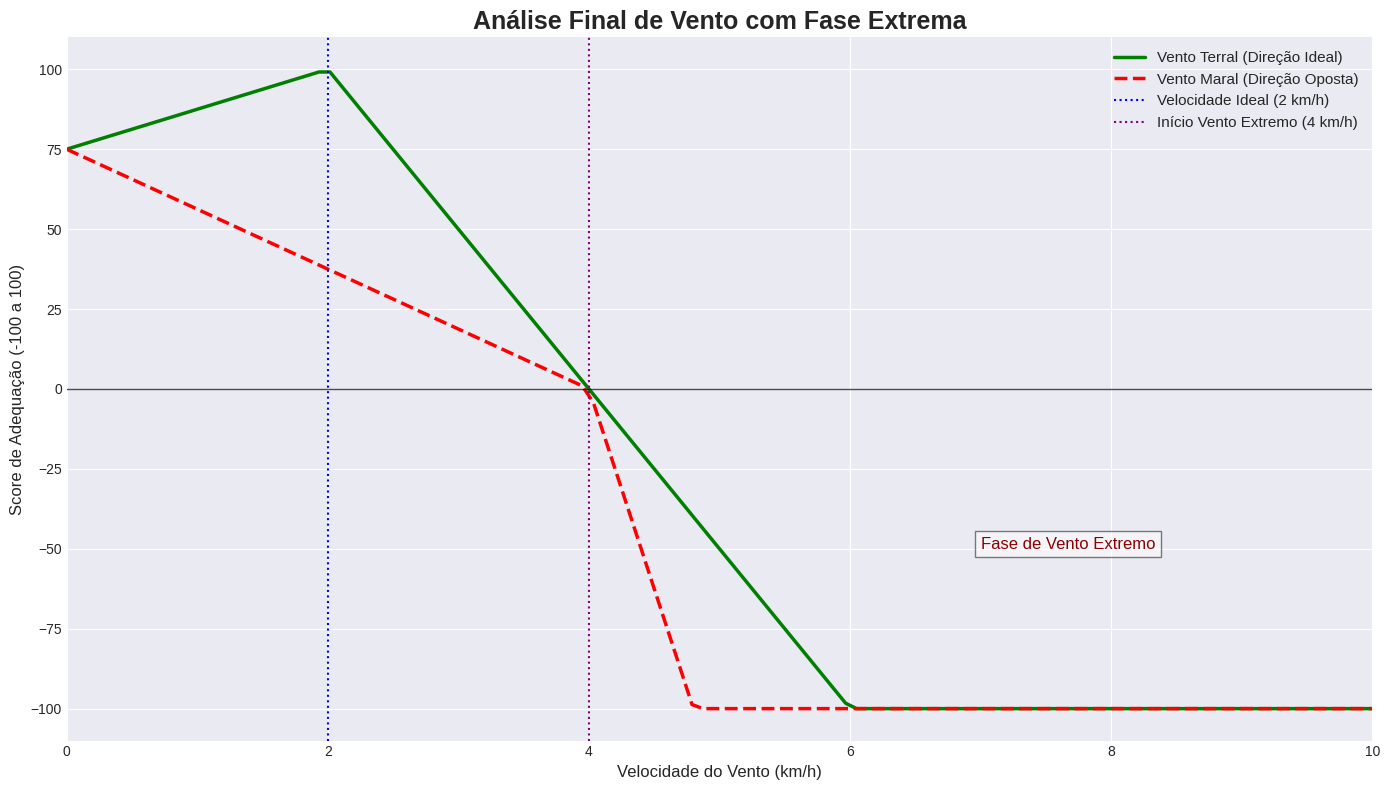

In [56]:
# --- Parâmetros de Simulação ---
preferred_wind_dir = 0
ideal_wind_speed = 2
max_wind_speed = 4

# Range de velocidades para incluir a fase de vento extremo
velocidades_vento = np.linspace(0, 10, 120)
maral_dir = preferred_wind_dir + 180

# --- Cálculo dos Scores ---
scores_terral = calcular_score_vento(
    velocidades_vento, preferred_wind_dir, preferred_wind_dir,
    ideal_wind_speed, max_wind_speed
)
scores_maral = calcular_score_vento(
    velocidades_vento, maral_dir, preferred_wind_dir,
    ideal_wind_speed, max_wind_speed
)

# --- Plotagem com Matplotlib ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(velocidades_vento, scores_terral, label='Vento Terral (Direção Ideal)', color='green', linewidth=2.5)
ax.plot(velocidades_vento, scores_maral, label='Vento Maral (Direção Oposta)', color='red', linewidth=2.5, linestyle='--')

ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.7)
ax.axvline(ideal_wind_speed, color='blue', linestyle=':', linewidth=1.5, label=f'Velocidade Ideal ({ideal_wind_speed} km/h)')
ax.axvline(max_wind_speed, color='purple', linestyle=':', linewidth=1.5, label=f'Início Vento Extremo ({max_wind_speed} km/h)')

ax.set_title('Análise Final de Vento com Fase Extrema', fontsize=18, fontweight='bold')
ax.set_xlabel('Velocidade do Vento (km/h)', fontsize=12)
ax.set_ylabel('Score de Adequação (-100 a 100)', fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(-110, 110)

# Ajuste no X para vermos a nova lógica
ax.set_xlim(0, 10)

# Anotação para a nova fase
ax.text(7, -50, 'Fase de Vento Extremo', fontsize=12, color='darkred', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()
